# Fine tune BERT

This notebook fine tunes a BERT model using 2000 human labeled comments. Then, we used this fine-tuned BERT to get labels for all comments

In [ ]:
import pandas as pd 
import numpy as np 
# sklearn machine learning and measurements packages
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, confusion_matrix

# deep learning packages for bert
import torch
!pip install -q transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertModel, TrainingArguments, Trainer, pipeline
!pip install datasets
from datasets import load_metric, load_dataset

# visualization and standard library packages
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from tqdm import tqdm
from collections import Counter
import os

%matplotlib inline

RANDOM_STATE = 42

In [3]:
# change to your local directory
cd /content/drive/MyDrive/Colab_Notebooks/Sentiment_Shift_proj/Sentiment_Shift

/content/drive/MyDrive/Colab_Notebooks/Sentiment_Shift_proj/Sentiment_Shift


In [3]:
!nvidia-smi

Thu Nov 24 23:20:33 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Split train, eval, test set

The two data samples are first sampled from comments with rating 1,2,4,5 and comments with rating 3 or NaN, then labeled by two individual labelers.

Map:
  * 0: negative
  * 1: neutral
  * 2: positive

In [4]:
data_df1 = pd.read_excel(f"{os.getcwd()}/labeled_comments/data_rating_1_2_4_5.xlsx")
data_df1 = data_df1.drop(data_df1.columns[[0, 1]], axis = 1)
data_df1['human_label'] = data_df1['human_label'] + 1 

data_df2 = pd.read_excel(f"{os.getcwd()}/labeled_comments/data_rating_3_NaN.xlsx")
data_df2 = data_df2.drop(data_df2.columns[[0, 1]], axis = 1)
data_df2['human_label'] = data_df2['human_label'] +1 

In [5]:
data_df1

,comment_time,movie_id,human_label,content
0,2012-08-31 21:00:05,4833574,2,钟爱苗圃。
1,2011-04-13 00:26:32,3015835,2,爱人讲Timing，做正选是时机，做后备是命运。受伤=无意识的成长。女人说的永远和心里想的不...
2,2015-12-23 19:59:54,25881247,2,非常老套的故事，女主没写好故事有点散前半有点虚张声势。法律无法生存的混乱边境里被复仇吞噬的一...
3,2019-05-29 22:55:04,30426860,1,掸脏胆抉
4,2019-09-03 16:26:03,2149806,2,逝去并不是终结，而是超越，走向下一程。至亲的生离死别，每个人终将会经历，被留下的人是很痛苦的...
...,...,...,...,...
995,2017-09-09 21:51:26,26800974,2,电影还可以啊，为什么评分这么低。。。。就是最后男主的名牌，那个镜头实在是太暗了，我看不清男主...
996,2019-02-05 21:57:11,6001038,2,温情治愈 不忘初心 要为村庄带去光明啊！
997,2016-01-02 23:07:24,1428119,1,2016第二部，芙芙。
998,2015-03-12 19:43:59,6005532,1,看看


In [6]:
Counter(data_df1['human_label']), Counter(data_df2['human_label'])

(Counter({2: 429, 1: 398, 0: 173}), Counter({1: 311, 0: 408, 2: 281}))

**check comment length**

In [7]:
def check_length(comments):
  len_128 = 0
  len_256 = 0
  for _, comment in tqdm(comments.iterrows()):
    try: 
      len_comment = len(comment['content'])
    except TypeError:
      len_comment = len(str(comment['content']))

    if len_comment > 128:
      len_128 += 1
    if len_comment > 256:
      len_256 += 1 
  return len_128, len_256

In [8]:
check_length(data_df1), check_length(data_df2)

1000it [00:00, 18975.06it/s]
1000it [00:00, 23412.12it/s]


((49, 0), (49, 2))

Only 2 comments have more than 256 tokens, so we use a max length of 256 for tokenize comments

In [9]:
def get_train_eval_test(example_df1, example_df2):
  '''
  train : eval : test = 6 : 2 : 2
  '''
  def split_data (example_df):
    train_eval_idx, test_idx = train_test_split(example_df.index, 
                                        test_size=0.2, 
                                        random_state=RANDOM_STATE)
    train_eval_comments = example_df.iloc[train_eval_idx, :].reset_index(drop=True)
    test_comments = example_df.iloc[test_idx, :].reset_index(drop=True)

    train_idx, eval_idx = train_test_split(train_eval_comments.index, 
                                                  test_size=0.25, 
                                                  random_state=RANDOM_STATE)
    train_comments = train_eval_comments.iloc[train_idx, :].reset_index(drop=True)
    eval_comments = train_eval_comments.iloc[eval_idx, :].reset_index(drop=True)

    return train_comments, eval_comments, test_comments
  
  # we don't use to_csv() here is because simply use to_csv() would yield 
  # wrongly formatted csv files.
  def write_csv(example_df, file_dir):
    '''
    write example DataFrame into the given file directory 
    '''
    with open(file_dir, 'w') as f:
      writer = csv.writer(f, delimiter=',')
      # write column names 
      writer.writerow(('index',
                      'comment_time',
                      'movie_id',
                      'human_label',
                      'content'))
      for idx, row in tqdm(example_df.iterrows()):
              writer.writerow((idx,
                              row['comment_time'],
                              row['movie_id'],
                              row['human_label'],
                              row['content']))

  train_comments_1, eval_comments_1, test_comments_1 = split_data(example_df1)
  train_comments_2, eval_comments_2, test_comments_2 = split_data(example_df2)
  
  train_set = pd.concat([train_comments_1, train_comments_2]).reset_index(drop=True)
  eval_set = pd.concat([eval_comments_1, eval_comments_2]).reset_index(drop=True)
  test_set = pd.concat([test_comments_1, test_comments_2]).reset_index(drop=True)
  file_train = f'{os.getcwd()}/labeled_comments/train_data.csv'
  file_eval = f'{os.getcwd()}/labeled_comments/eval_data.csv'
  file_test = f'{os.getcwd()}/labeled_comments/test_data.csv'
  write_csv(train_set, file_train)
  write_csv(eval_set, file_eval)
  write_csv(test_set, file_test)

In [10]:
get_train_eval_test(data_df1, data_df2)

1200it [00:00, 13981.01it/s]
400it [00:00, 14387.58it/s]
400it [00:00, 16696.90it/s]


## Fine-tune BERT

In [11]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")
model = AutoModelForSequenceClassification.from_pretrained("bert-base-chinese", num_labels=3)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/624 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/412M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [12]:
# max length is decided according to previous examination
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", max_length=256, truncation=True)

In [13]:
dataset = load_dataset('csv', data_files={'train': f'{os.getcwd()}/labeled_comments/train_data.csv',
                                          'test': f'{os.getcwd()}/labeled_comments/eval_data.csv',})
dataset = dataset.rename_column("content", "text")
dataset = dataset.rename_column("human_label", "label")
dataset = dataset.remove_columns(['index', 'comment_time','movie_id'])
dataset

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-0e7d63d1974feff9/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1200
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 400
    })
})

In [14]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [15]:
train_dataset = tokenized_datasets["train"].shuffle(seed=RANDOM_STATE)
eval_dataset = tokenized_datasets["test"].shuffle(seed=RANDOM_STATE)

In [16]:
training_args = TrainingArguments(output_dir=f"{os.getcwd()}/output_bert", 
                                  num_train_epochs=4,
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  save_strategy = "epoch",
                                  # save_steps = 10000,
                                  evaluation_strategy="epoch")
metric = load_metric("accuracy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  


In [17]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

In [22]:
model_dir = f"{os.getcwd()}/output_bert/model"
model.save_pretrained(model_dir)

Configuration saved in /content/drive/MyDrive/Colab_Notebooks/Sentiment_Shift_proj/Sentiment_Shift/output_bert/model/config.json
Model weights saved in /content/drive/MyDrive/Colab_Notebooks/Sentiment_Shift_proj/Sentiment_Shift/output_bert/model/pytorch_model.bin


## Test fine-tuned BERT

In [2]:
model_dir = f"{os.getcwd()}/output_bert/model"
model = AutoModelForSequenceClassification.from_pretrained(model_dir, num_labels=3)
tokenizer = AutoTokenizer.from_pretrained("bert-base-chinese")

In [3]:
#set the model to cpu mode for evaluation
model = model.cpu()
text_classification = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

In [4]:
def sentiment_analysis(example_df):
  '''
  Using fine-tuned bert  model to get 
  the sentiment label

  Inputs:
    test_comments:DataFrame

  Outputs:
    sentiment_label: list of sentiment labels
  '''
  sentiment_label = []
  scores = []
  # This operation would take a very long time, 
  # so we use tqdm to reduce our anxiery :)
  for comment in tqdm(example_df['content']):
      sent = text_classification(comment)[0]
      if sent['label'] == 'LABEL_0':
        sentiment_label.append(0)
      elif sent['label'] == 'LABEL_1':
        sentiment_label.append(1)
      else:
        sentiment_label.append(2)
      scores.append(sent['score'])
  return sentiment_label, scores

In [7]:
test_comments = pd.read_csv(f'{os.getcwd()}/labeled_comments/test_data.csv')

In [8]:
y_label, scores = sentiment_analysis(test_comments)

100%|██████████| 400/400 [02:08<00:00,  3.12it/s]


In [9]:
test_comments['pred_label'] = y_label
test_comments['pred_score'] = scores

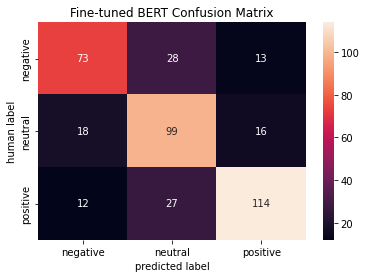

In [10]:
con_matrix_bert = confusion_matrix(test_comments['human_label'], y_label)
fig, ax = plt.subplots()
sns.heatmap(con_matrix_bert, annot=True, fmt='d',
            xticklabels=['negative', 'neutral', 'positive'], 
            yticklabels=['negative', 'neutral', 'positive'])
plt.xlabel('predicted label')
plt.ylabel('human label')
plt.title("Fine-tuned BERT Confusion Matrix")
fig.savefig(f'{os.getcwd()}/figs/confusion_matrix.png')

**Matthews correlation**

According to [sklearn's introduction](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), Matthews correlation coefficient could be used as a measure of the quality of classification even if the dataset is unbalanced. It ranges from -1 to 1, where 1 means perfect prediction.

Equation: 
$$ 
    MCC = \frac{TP*TN -FP*FN}{\sqrt{(TP + FP)(TP + FN)(TN + FP)(TN + FN)}}
$$

In [11]:
matthews_corrcoef(test_comments['human_label'], y_label)

0.5711811827355154

The score is not bad considering the vague nature of movie commments

## Label all movie comments

In [5]:
comments = pd.read_csv(f'{os.getcwd()}/comments.csv', dtype={'CONTENT': str})

In [6]:
comments = comments.loc[:, ['COMMENT_TIME','COMMENT_ID','MOVIE_ID', 'USER_MD5','CONTENT', 'VOTES', 'RATING']]
comments = comments.rename(columns={'COMMENT_ID':'comment_id',
                                    'COMMENT_TIME':'comment_time',
                                    'MOVIE_ID':'movie_id',
                                    'RATING':'rating',
                                    'CONTENT':'content',
                                   'USER_MD5':'user_md5',
                                   'VOTES':'votes'})
comments

,comment_time,comment_id,movie_id,user_md5,content,votes,rating
0,2018-09-05 19:42:07,1359352573,5113101,0ab7e3efacd56983f16503572d2b9915,480p，画质不高，黑白，y,0,2.0
1,2019-07-09 14:52:07,1598245094,5113101,84dfd3f91dd85ea105bc74a4f0d7a067,毫无看点，黑白画质，一个男人孤独的心理情景历程，疯疯癫癫，没有任何恐怖的成分，这应该是剧情片吧.,0,1.0
2,2010-11-05 22:15:44,311937819,3718526,c9a47fd59b55967ceac07cac6d5f270c,上吊那裡超好笑，可惜最後報告近況的旁白大扣分,0,3.0
3,2010-06-20 02:12:50,262536568,3718526,35d3d5a52a7515c2ca6bb4d8e965149b,上海国际电影节观摩片,0,NaN
4,2011-04-09 22:10:13,376372407,3718526,54bfe88b57d8a3caea2637e62d182cf7,！,0,NaN
...,...,...,...,...,...,...,...
4428470,2018-07-08 17:48:09,1402192514,26914297,517cd1ba10c6bf42465184808ec80c1f,歌舞精良，但是故事情节看的真是闹心。在时代的大背景下，谁都无法独善其身。,0,5.0
4428471,2017-01-03 17:55:35,1131394883,26914297,9b03a9f6953b06611e3352a889ecdfa2,麦金托什的25周年全部是视觉路线,0,4.0
4428472,2018-12-10 20:09:20,1565118781,26914297,4f696ad30cec6601ca49dfc2281985f3,记不住里面任何一首歌，就觉得胖女孩的胳膊记忆犹新,0,3.0
4428473,2019-08-03 14:39:02,1888955067,26914297,9b32c4b5f73092083e23669ea6731b86,故事不喜欢，但是场景精致，唱段好听。,0,4.0


In [7]:
# check empty content
empty_lst = []
error_lst = []
for index, row in tqdm(comments.iterrows()):
    try:
        if not row['content'].strip():
            empty_lst.append(index)
    except AttributeError:
        error_lst.append(index)

4428475it [02:45, 26702.45it/s]


In [8]:
comments.drop(empty_lst + error_lst, axis=0, inplace=True)

In [9]:
# drop super long comments
long_lst = []
for index, row in tqdm(comments.iterrows()):
    if len(row['content'].strip()) >=512:
        long_lst.append(index)
comments.drop(long_lst, axis=0, inplace=True)

4428464it [02:54, 25408.73it/s]


In [10]:
comments = comments.reset_index(drop=True)
comments

,comment_time,comment_id,movie_id,user_md5,content,votes,rating
0,2018-09-05 19:42:07,1359352573,5113101,0ab7e3efacd56983f16503572d2b9915,480p，画质不高，黑白，y,0,2.0
1,2019-07-09 14:52:07,1598245094,5113101,84dfd3f91dd85ea105bc74a4f0d7a067,毫无看点，黑白画质，一个男人孤独的心理情景历程，疯疯癫癫，没有任何恐怖的成分，这应该是剧情片吧.,0,1.0
2,2010-11-05 22:15:44,311937819,3718526,c9a47fd59b55967ceac07cac6d5f270c,上吊那裡超好笑，可惜最後報告近況的旁白大扣分,0,3.0
3,2010-06-20 02:12:50,262536568,3718526,35d3d5a52a7515c2ca6bb4d8e965149b,上海国际电影节观摩片,0,NaN
4,2011-04-09 22:10:13,376372407,3718526,54bfe88b57d8a3caea2637e62d182cf7,！,0,NaN
...,...,...,...,...,...,...,...
4428390,2018-07-08 17:48:09,1402192514,26914297,517cd1ba10c6bf42465184808ec80c1f,歌舞精良，但是故事情节看的真是闹心。在时代的大背景下，谁都无法独善其身。,0,5.0
4428391,2017-01-03 17:55:35,1131394883,26914297,9b03a9f6953b06611e3352a889ecdfa2,麦金托什的25周年全部是视觉路线,0,4.0
4428392,2018-12-10 20:09:20,1565118781,26914297,4f696ad30cec6601ca49dfc2281985f3,记不住里面任何一首歌，就觉得胖女孩的胳膊记忆犹新,0,3.0
4428393,2019-08-03 14:39:02,1888955067,26914297,9b32c4b5f73092083e23669ea6731b86,故事不喜欢，但是场景精致，唱段好听。,0,4.0


In [ ]:
y_label_all, _ = sentiment_analysis(comments)
comments['pred_label'] = y_label_all

In [ ]:
# we don't use to_csv() here is because simply use to_csv() would yield 
# wrongly formatted csv files.
def write_csv_2(example_df, file_dir):
  '''
  write example DataFrame into the given file directory 
  '''
  with open(file_dir, 'w') as f:
    writer = csv.writer(f, delimiter=',')
    # write column names 
    writer.writerow(('index',
                     'comment_time',
                     'comment_id',
                     'movie_id',
                     'user_md5',
                     'rating',
                     'votes',
                     'content',
                     'pred_label'
                     ))
    for idx, row in tqdm(example_df.iterrows()):
            writer.writerow((idx,
                             row['comment_time'],
                             row['comment_id'],
                             row['movie_id'],
                             row['user_md5'],
                             row['rating'],
                             row['votes'],
                             row['content'],
                             row['pred_label']
                             ))

In [16]:
file_dir = f'{os.getcwd()}/comments_cleaned.csv'
write_csv_2(comments, file_dir)

4428395it [04:39, 15819.78it/s]
